In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# reflect the tables
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent

'2017-08-23'

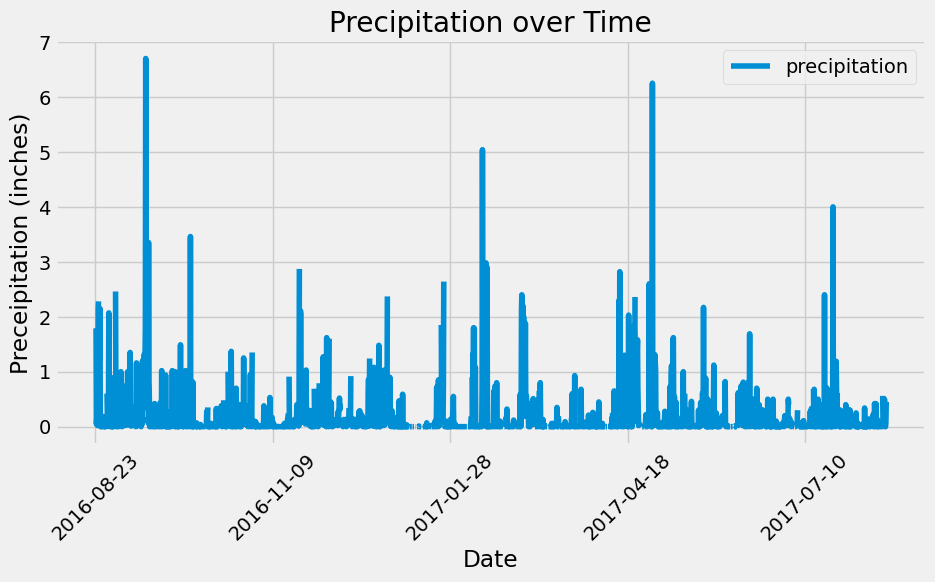

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
most_recent_date = dt.datetime.strptime(most_recent, '%Y-%m-%d').date()
starting_date = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= starting_date).\
            filter(Measurement.date <= most_recent_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'precipitation']).set_index('date')

# Sort the dataframe by date
df = df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(10,5))
plt.title("Precipitation over Time")
plt.xlabel("Date")
plt.ylabel("Preceipitation (inches)")
plt.legend(loc="upper right")
plt.xticks(rotation=45)
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_stats = df['precipitation'].describe()
print(precip_stats)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Station.station).count()
station_count

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
from sqlalchemy import desc
station_activity = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.station))).all()

station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, 
# calculate the lowest, highest, and average temperature.
most_active_station = session.query(func.min(Measurement.tobs),
                       func.max(Measurement.tobs),
                       func.avg(Measurement.tobs)).\
                        filter(Measurement.station==station_activity[0][0]).all()
most_active_station

[(54.0, 85.0, 71.66378066378067)]

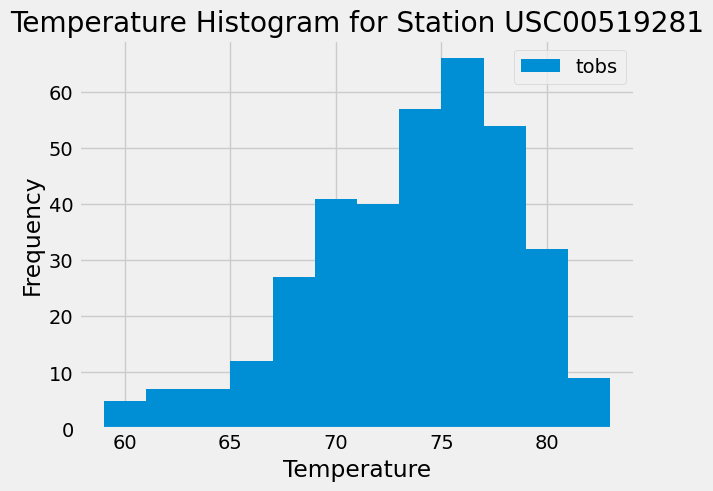

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station 
# and plot the results as a histogram

# Calculate most recent date for specific station
most_recent_active_station = session.query(Measurement.date).\
                            filter(Measurement.station==station_activity[0][0]).\
                            order_by(Measurement.date.desc()).first()[0]

# Convert date string to date object and calculate starting date
most_recent_date_active_station = dt.datetime.strptime(most_recent_active_station,'%Y-%m-%d').date()
starting_date_active_station = most_recent_date_active_station - dt.timedelta(days=365)

# Query to retrieve data
last_twelve_months_query = session.query(Measurement.tobs).\
                            filter(Measurement.station==station_activity[0][0]).\
                            filter(Measurement.date >= starting_date_active_station).\
                            filter(Measurement.date <= most_recent_date_active_station).all()

#Convert query to df to plot
last_twelve_months_df = pd.DataFrame(last_twelve_months_query, columns=['tobs'])

last_twelve_months_df.plot.hist(bins=12)
plt.title(f'Temperature Histogram for Station {station_activity[0][0]}')
plt.xlabel('Temperature')
plt.yticks(range(0, int(plt.gca().get_ylim()[1]),10))
plt.show()

# Close Session

In [16]:
# Close Session
session.close()